In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# to enable imports from parent package
import sys
import os
from pathlib import Path
parent_dir = Path(os. getcwd()).parent.absolute()
sys.path.append(str(parent_dir))

import torch
import numpy as np
import os.path as osp
import pandas as pd
import seaborn as sns

from attacks.data_recorder import compute_regression_metrics
from plots import aggregate_over_splits, remove_unused_categories, palette, model_types, group, remove_top_percentage, groupby_to_table, rename_col, concatenate, append_model_type, compute_baseline_score, line_type

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Liberation Sans']})
import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt



device = ('cuda' if torch.cuda.is_available() else
          'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}')

plots_dir = 'output'
dataset_name = "MUTAG"


Device: cuda


In [3]:
adversarially_trained = [
    "GINE_MUTAG_300_5_0_20230804-094645",
    "GINE_MUTAG_300_5_1_20230804-113531",
    "GINE_MUTAG_300_5_2_20230804-124836",
    "GINE_MUTAG_300_5_3_20230804-145430",
    "GINE_MUTAG_300_5_4_20230804-163447",
    "DropGINE_MUTAG_300_5_0_20230804-095856",
    "DropGINE_MUTAG_300_5_1_20230804-114811",
    "DropGINE_MUTAG_300_5_2_20230804-125807",
    "DropGINE_MUTAG_300_5_3_20230804-145904",
    "DropGINE_MUTAG_300_5_4_20230804-164729",
    "PPGN_MUTAG_300_5_0_20230804-103501",
    "PPGN_MUTAG_300_5_1_20230804-120842",
    "PPGN_MUTAG_300_5_2_20230804-133403",
    "PPGN_MUTAG_300_5_3_20230804-153502",
    "PPGN_MUTAG_300_5_4_20230804-172311",
    "SignNet_MUTAG_95_16_0_20230804-110442",
    "SignNet_MUTAG_95_16_1_20230804-121614",
    "SignNet_MUTAG_95_16_2_20230804-134125",
    "SignNet_MUTAG_95_16_3_20230804-160412",
    "SignNet_MUTAG_95_16_4_20230804-173013",
    "ESAN_MUTAG_64_5_0_20230804-094651",
    "ESAN_MUTAG_64_5_1_20230804-110703",
    "ESAN_MUTAG_64_5_2_20230804-122931",
    "ESAN_MUTAG_64_5_3_20230804-135018",
    "ESAN_MUTAG_64_5_4_20230804-151411",
    "MeanAggrGINE_MUTAG_300_5_0_20230804-111829",
    "MeanAggrGINE_MUTAG_300_5_1_20230804-123016",
    "MeanAggrGINE_MUTAG_300_5_2_20230804-143620",
    "MeanAggrGINE_MUTAG_300_5_3_20230804-161640",
    "MeanAggrGINE_MUTAG_300_5_4_20230804-174357",
    "GIN_MUTAG_300_5_0_20230804-191701",
    "GIN_MUTAG_300_5_1_20230804-192711",
    "GIN_MUTAG_300_5_2_20230804-194031",
    "GIN_MUTAG_300_5_3_20230804-195432",
    "GIN_MUTAG_300_5_4_20230804-201138",
]

In [4]:
from tqdm import tqdm
from run_attacks import all_tasks

results_directory = '../results/'

def load_data(all_tasks, dataset_name, tasks_to_load=[], sortby=["model", "task", "id"], apply_transform=None):
    data = []

    if tasks_to_load:
        filter_tasks = lambda tasks: {task: val for task, val in tasks.items() if any(t in task for t in tasks_to_load)}
        all_tasks = {model_name: filter_tasks(val) for model_name, val in all_tasks.items() if dataset_name in model_name}

    for model_name, tasks in tqdm(all_tasks.items()):
        # if not dataset_name in model_name:
        #     continue
        model_type = model_name.split("_")[0]
        dataset = model_name.split("_")[1]

        for task_name, task in tasks.items():
            path = osp.join(results_directory, dataset, model_name, f"{task_name}.data")
            if not osp.exists(path):
                continue

            df = pd.read_pickle(path)
            if apply_transform is not None:
                    df = apply_transform(df)
            data.append(df)
            # try:
            #     df = pd.read_pickle(path)
            #     data.append(df)
            # except Exception as e:
            #     print(f"ERROR when reading task '{task_name}' of '{model_name}'")
            #     print(e)

    def short_model_names_map(df, prefix_len=1):
        model_names = set(df["model"].values)
        count = {}
        rename_map = {}
        for model_name in model_names:
            prefix = "_".join(model_name.split("_")[:prefix_len])
            if model_name in adversarially_trained:
                prefix = f"{prefix}-adv"
            if not prefix in count:
                count[prefix] = 0
            rename_map[model_name] = f"{prefix}_{count[prefix]}"
            count[prefix] += 1
        return rename_map
    
    data = concatenate(data)
    data.sort_values(sortby, inplace=True)
    data = data.reset_index(drop=True)
    model_name_map = short_model_names_map(data)
    data["model"] = data["model"].cat.rename_categories(model_name_map)
    append_model_type(data)
    data["model_rep"] = [int(x[-1]) for x in data["model"]]
    data = data[~data["id"].isna()]
    data["id"] = data["id"].astype("int32")

    if (data["is_undirected"] == 0).any():
        mask = data["is_undirected"] == 0
        print("found directed perturbation")
        print(data[mask])
    # assert (data["is_undirected"] == 1).all()

    data["acc"] = 1 - data["missclassified"]

    return data


## Original Data

In [5]:
def advtrain_to_table(df, round_to=3):
    df = df[["model", "acc", "lbl_diff"]].copy()
    clean_df = df[~df["model"].str.contains("adv")]
    adv_df = df[df["model"].str.contains("adv")].rename(columns={"acc": "acc-adv", "lbl_diff": "lbl_diff-adv"})
    adv_df["model"] = [model_name.replace("-adv", "") for model_name in adv_df["model"]]

    df = clean_df.merge(adv_df, on="model")
    append_model_type(df)
    df = df.drop(columns="model")
    grouped = df.groupby("model_type")
    mean = grouped.mean().round(round_to)
    std = grouped.std().round(round_to)
    orig_cols = mean.columns
    mean["diff_acc"] = "$" + (mean["acc-adv"] - mean["acc"]).round(round_to).astype(str) + "$"
    mean["diff_lbl_diff"] = "$" + (mean["lbl_diff"] - mean["lbl_diff-adv"]).round(round_to).astype(str) + "$"
    for col in orig_cols:
        mean[col] = "$" + mean[col].astype(str) + " \pm " + std[col].astype(str) + "$"

    return mean.reset_index()[["model_type", "acc", "acc-adv", "diff_acc", "lbl_diff", "lbl_diff-adv", "diff_lbl_diff"]]

In [6]:
orig_data = load_data(all_tasks, dataset_name, ["original"])

pd.pivot_table(orig_data[["model_type", "y"]], columns="model_type", aggfunc="count")

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:00<00:00, 1670.51it/s]


model_type,Baseline,DropGINE,DropGINE-adv,ESAN,ESAN-adv,GIN,GIN-adv,GINE,GINE-adv,PPGN,PPGN-adv,SignNet,SignNet-adv,meanGINE,meanGINE-adv
y,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95


In [7]:
orig_per_model = group(orig_data, ["model"]).mean().reset_index()
append_model_type(orig_per_model)
orig_per_model["budget"] = 0

# plot = sns.barplot(data=orig_per_model, x="model_type", y="acc", hue="model_rep")

# groupby_to_table(orig_per_model[["model_type", "acc", "lbl_diff"]].groupby("model_type"))
advtrain_to_table(orig_per_model)

,model_type,acc,acc-adv,diff_acc,lbl_diff,lbl_diff-adv,diff_lbl_diff
0,DropGINE,$0.947 \pm 0.037$,$0.916 \pm 0.029$,$-0.031$,$0.054 \pm 0.026$,$0.102 \pm 0.018$,$-0.048$
1,ESAN,$0.979 \pm 0.029$,$0.905 \pm 0.058$,$-0.074$,$0.031 \pm 0.013$,$0.118 \pm 0.043$,$-0.087$
2,GIN,$0.947 \pm 0.037$,$0.874 \pm 0.06$,$-0.073$,$0.085 \pm 0.024$,$0.186 \pm 0.033$,$-0.101$
3,GINE,$0.989 \pm 0.024$,$0.853 \pm 0.058$,$-0.136$,$0.019 \pm 0.012$,$0.157 \pm 0.048$,$-0.138$
4,PPGN,$0.853 \pm 0.044$,$0.779 \pm 0.024$,$-0.074$,$0.176 \pm 0.013$,$0.274 \pm 0.026$,$-0.098$
5,SignNet,$0.958 \pm 0.058$,$0.726 \pm 0.242$,$-0.232$,$0.153 \pm 0.05$,$0.337 \pm 0.125$,$-0.184$
6,meanGINE,$0.874 \pm 0.047$,$0.747 \pm 0.044$,$-0.127$,$0.172 \pm 0.076$,$0.292 \pm 0.032$,$-0.12$


## Bruteforce Data

In [8]:
bf_data = load_data(all_tasks, dataset_name, ["bruteforce"])
pd.pivot_table(bf_data, index=["task", "perturbation"], columns="model_type", aggfunc="count")["y"] # should be 95 everywhere

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:00<00:00, 586.34it/s]


model_type                   DropGINE  DropGINE-adv  ESAN  ESAN-adv  GIN  \
task       perturbation                                                    
bruteforce add-edge                95            95    95        95   95   
           drop-edge               95            95    95        95   95   
           modify-edge-attr        95            95    95        95    0   
           modify-node-attr        95            95    95        95   95   

model_type                   GIN-adv  GINE  GINE-adv  PPGN  PPGN-adv  SignNet  \
task       perturbation                                                         
bruteforce add-edge               95    95        95    95        95       95   
           drop-edge              95    95        95    95        95       95   
           modify-edge-attr        0    95        95    95        95       95   
           modify-node-attr       95    95        95    95        95       95   

model_type                   SignNet-adv  meanGINE  meanGINE-adv  
task       perturbation                                           
bruteforce add-edge                   95        95            95  
           drop-edge                  95        95            95  
           modify-edge-attr           95        95            95  
           modify-node-attr           95        95            95

In [9]:
## ADJACENCY PERTURBATION
adjbf_data = remove_unused_categories(bf_data[bf_data["perturbation"].isin(["add-edge", "drop-edge"])])
adjbf_agg = aggregate_over_splits(adjbf_data, group_by=adjbf_data["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
adjbf_agg["task_type"] = "adj_bf"

per_model = group(adjbf_agg, ["model"]).mean().reset_index()
append_model_type(per_model)
advtrain_to_table(per_model)

,model_type,acc,acc-adv,diff_acc,lbl_diff,lbl_diff-adv,diff_lbl_diff
0,DropGINE,$0.2 \pm 0.164$,$0.495 \pm 0.071$,$0.295$,$0.797 \pm 0.15$,$0.522 \pm 0.072$,$0.275$
1,ESAN,$0.147 \pm 0.114$,$0.516 \pm 0.101$,$0.369$,$0.857 \pm 0.093$,$0.508 \pm 0.076$,$0.349$
2,GIN,$0.0 \pm 0.0$,$0.189 \pm 0.103$,$0.189$,$0.957 \pm 0.013$,$0.76 \pm 0.059$,$0.197$
3,GINE,$0.189 \pm 0.088$,$0.4 \pm 0.06$,$0.211$,$0.796 \pm 0.079$,$0.591 \pm 0.055$,$0.205$
4,PPGN,$0.589 \pm 0.094$,$0.589 \pm 0.024$,$0.0$,$0.488 \pm 0.107$,$0.43 \pm 0.028$,$0.058$
5,SignNet,$0.021 \pm 0.047$,$0.326 \pm 0.256$,$0.305$,$0.922 \pm 0.125$,$0.657 \pm 0.153$,$0.265$
6,meanGINE,$0.084 \pm 0.121$,$0.211 \pm 0.064$,$0.127$,$0.874 \pm 0.078$,$0.758 \pm 0.036$,$0.116$


In [10]:
table = pd.pivot_table(adjbf_agg, index=["perturbation"], columns="model_type", aggfunc="count")["y"] / 95
table = table[["meanGINE", "meanGINE-adv", "GIN", "GIN-adv", "GINE", "GINE-adv", "SignNet", "SignNet-adv", "DropGINE", "DropGINE-adv", "ESAN", "ESAN-adv", "PPGN", "PPGN-adv"]]
table.style.format('{:,.1%}'.format)

model_type,meanGINE,meanGINE-adv,GIN,GIN-adv,GINE,GINE-adv,SignNet,SignNet-adv,DropGINE,DropGINE-adv,ESAN,ESAN-adv,PPGN,PPGN-adv
perturbation,,,,,,,,,,,,,,
add-edge,92.6%,68.4%,38.9%,74.7%,47.4%,69.5%,55.8%,75.8%,63.2%,68.4%,55.8%,66.3%,88.4%,82.1%
drop-edge,7.4%,31.6%,61.1%,25.3%,52.6%,30.5%,44.2%,24.2%,36.8%,31.6%,44.2%,33.7%,11.6%,17.9%


In [11]:
## ANY PERTURBATION

attrbf_data = bf_data.copy()
attrbf_data = remove_unused_categories(attrbf_data[(attrbf_data["model_type"]!="GIN")&(attrbf_data["model_type"]!="GIN-adv")]) # only include models with edge features

# combine adjacency perturbations
adj_pert = attrbf_data[attrbf_data["perturbation"].isin(["add-edge", "drop-edge"])]
adj_pert = aggregate_over_splits(adj_pert, group_by=adj_pert["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
attrbf_data = pd.concat(
    (attrbf_data[~attrbf_data["perturbation"].isin(["add-edge", "drop-edge"])],
     adj_pert))
pert = attrbf_data["perturbation"].astype(str)
pert[pert=="add-edge"] = "adjacency"
pert[pert=="drop-edge"] = "adjacency"
attrbf_data["perturbation"] = pert.astype("category")

attrbf_agg = aggregate_over_splits(attrbf_data, group_by=attrbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="lbl_diff")
attrbf_agg = aggregate_over_splits(attrbf_agg, group_by=attrbf_agg["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
attrbf_agg["task_type"] = "bf"

per_model = group(attrbf_agg, ["model"]).mean().reset_index()
append_model_type(per_model)
advtrain_to_table(per_model)

,model_type,acc,acc-adv,diff_acc,lbl_diff,lbl_diff-adv,diff_lbl_diff
0,DropGINE,$0.137 \pm 0.142$,$0.432 \pm 0.058$,$0.295$,$0.857 \pm 0.119$,$0.565 \pm 0.049$,$0.292$
1,ESAN,$0.105 \pm 0.064$,$0.495 \pm 0.109$,$0.39$,$0.894 \pm 0.057$,$0.532 \pm 0.068$,$0.362$
2,GINE,$0.158 \pm 0.118$,$0.379 \pm 0.044$,$0.221$,$0.825 \pm 0.094$,$0.603 \pm 0.049$,$0.222$
3,PPGN,$0.558 \pm 0.109$,$0.589 \pm 0.024$,$0.031$,$0.515 \pm 0.095$,$0.436 \pm 0.024$,$0.079$
4,SignNet,$0.021 \pm 0.047$,$0.305 \pm 0.267$,$0.284$,$0.922 \pm 0.125$,$0.676 \pm 0.161$,$0.246$
5,meanGINE,$0.011 \pm 0.024$,$0.137 \pm 0.029$,$0.126$,$0.975 \pm 0.016$,$0.82 \pm 0.029$,$0.155$


In [12]:
table = pd.pivot_table(attrbf_agg, index=["perturbation"], columns="model_type", aggfunc="count")["y"] / 95
table = table[["meanGINE", "meanGINE-adv", "GINE", "GINE-adv", "SignNet", "SignNet-adv", "DropGINE", "DropGINE-adv", "ESAN", "ESAN-adv", "PPGN", "PPGN-adv"]]
table.style.format('{:,.1%}'.format)

model_type,meanGINE,meanGINE-adv,GINE,GINE-adv,SignNet,SignNet-adv,DropGINE,DropGINE-adv,ESAN,ESAN-adv,PPGN,PPGN-adv
perturbation,,,,,,,,,,,,
adjacency,27.4%,43.2%,85.3%,86.3%,100.0%,86.3%,86.3%,68.4%,80.0%,80.0%,65.3%,58.9%
modify-edge-attr,28.4%,47.4%,0.0%,6.3%,0.0%,2.1%,3.2%,17.9%,0.0%,8.4%,10.5%,38.9%
modify-node-attr,44.2%,9.5%,14.7%,7.4%,0.0%,11.6%,10.5%,13.7%,20.0%,11.6%,24.2%,2.1%


## AdjPGD

In [13]:
adjpgd_data = load_data(all_tasks, dataset_name, ["adjpgd"])
pd.pivot_table(adjpgd_data, index=["task"], columns="model_type", aggfunc="count")["y"] # each entry should have 1425 values

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:00<00:00, 638.11it/s]


model_type,DropGINE,DropGINE-adv,ESAN,ESAN-adv,GIN,GIN-adv,GINE,GINE-adv,PPGN,PPGN-adv,SignNet,SignNet-adv,meanGINE,meanGINE-adv
task,,,,,,,,,,,,,,
adjpgd_abs,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425
adjpgd_rel,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


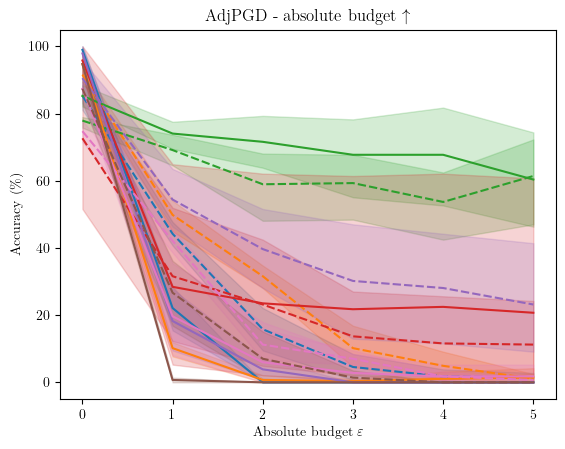

In [14]:
adjpgd_abs_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_abs"])]).copy()

per_model = group(adjpgd_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.title("AdjPGD - absolute budget $\\uparrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_adjpgd_acc_abs.pgf"), bbox_inches='tight')

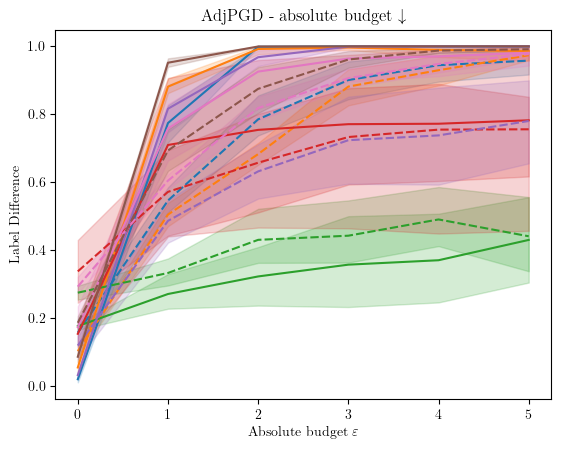

In [15]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.title("AdjPGD - absolute budget $\\downarrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_adjpgd_lbl_diff_abs.pgf"), bbox_inches='tight')

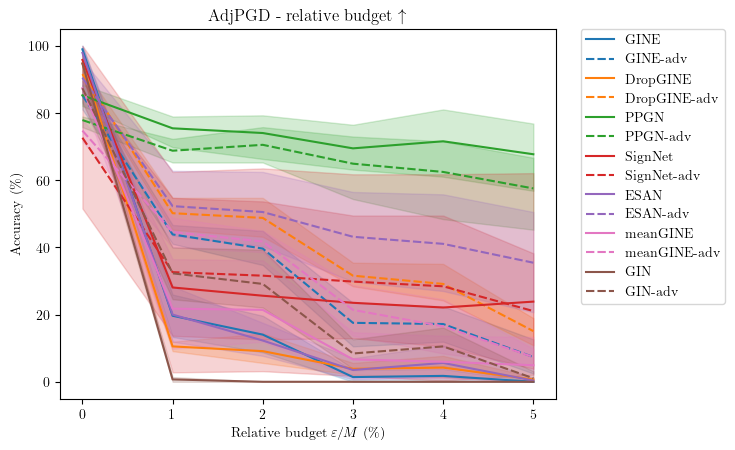

In [16]:
adjpgd_rel_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_rel"])]).copy()

per_model = group(adjpgd_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.title("AdjPGD - relative budget $\\uparrow$")
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_adjpgd_acc_rel.pgf"), bbox_inches='tight')

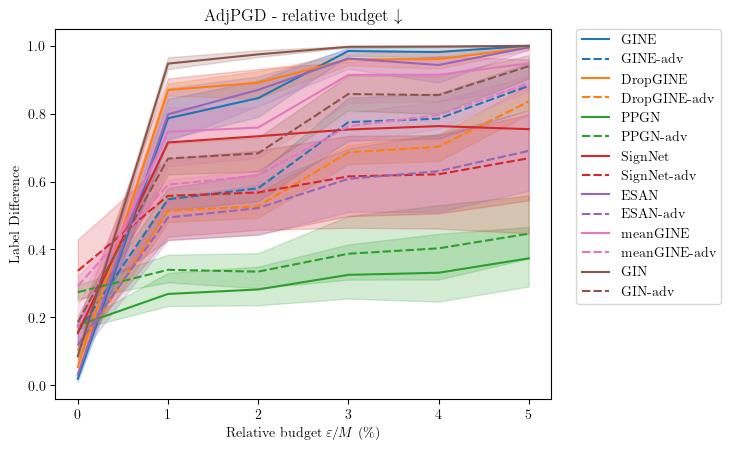

In [17]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.title("AdjPGD - relative budget $\\downarrow$")
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_adjpgd_lbl_diff_rel.pgf"), bbox_inches='tight')

## AttrPGD

In [18]:
attrpgd_data = load_data(all_tasks, dataset_name, ["attrpgd"])
pd.pivot_table(attrpgd_data, index=["task"], columns="model_type", aggfunc="count")["y"] # each entry should have 1425 values

100%|██████████| 75/75 [00:00<00:00, 636.86it/s]


model_type,DropGINE,DropGINE-adv,ESAN,ESAN-adv,GIN,GIN-adv,GINE,GINE-adv,PPGN,PPGN-adv,SignNet,SignNet-adv,meanGINE,meanGINE-adv
task,,,,,,,,,,,,,,
attrpgd_abs,475,475,475,475,475,475,475,475,475,475,475,475,475,475
attrpgd_rel,475,475,475,475,475,475,475,475,475,475,475,475,475,475


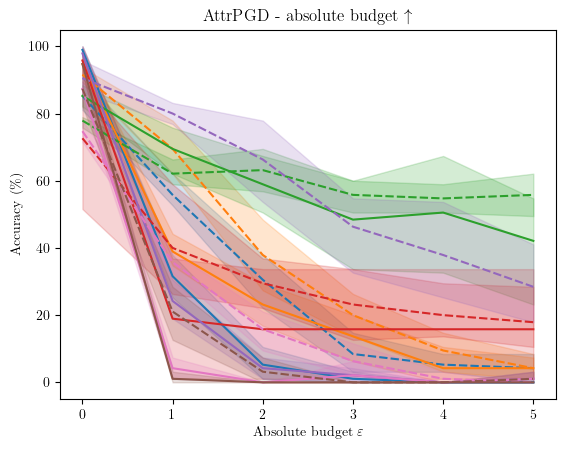

In [19]:
attrpgd_abs_data = remove_unused_categories(attrpgd_data[attrpgd_data["task"].isin(["attrpgd_abs"])]).copy()

per_model = group(attrpgd_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)

# groupby_to_table(per_model[["model_type", "budget", "acc", "lbl_diff"]].groupby(by=["model_type", "budget"]))

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.title("AttrPGD - absolute budget $\\uparrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_attrpgd_acc_abs.pgf"), bbox_inches='tight')

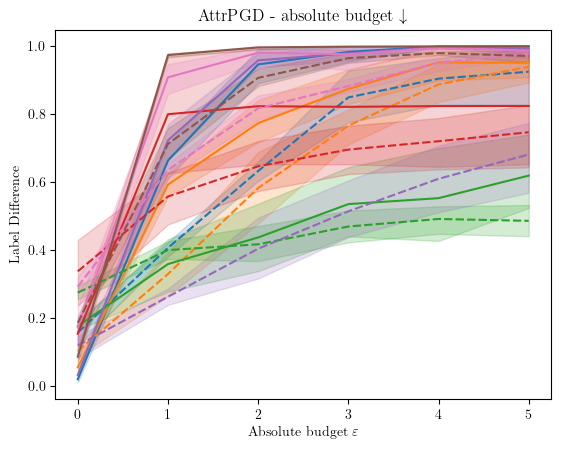

In [20]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.title("AttrPGD - absolute budget $\\downarrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_attrpgd_lbl_diff_abs.pgf"), bbox_inches='tight')

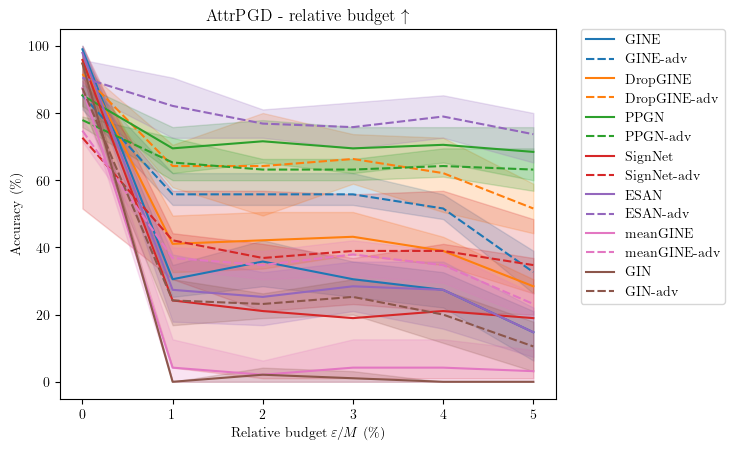

In [21]:
attrpgd_rel_data = remove_unused_categories(attrpgd_data[attrpgd_data["task"].isin(["attrpgd_rel"])]).copy()

per_model = group(attrpgd_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.title("AttrPGD - relative budget $\\uparrow$")
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([i for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_attrpgd_acc_rel.pgf"), bbox_inches='tight')

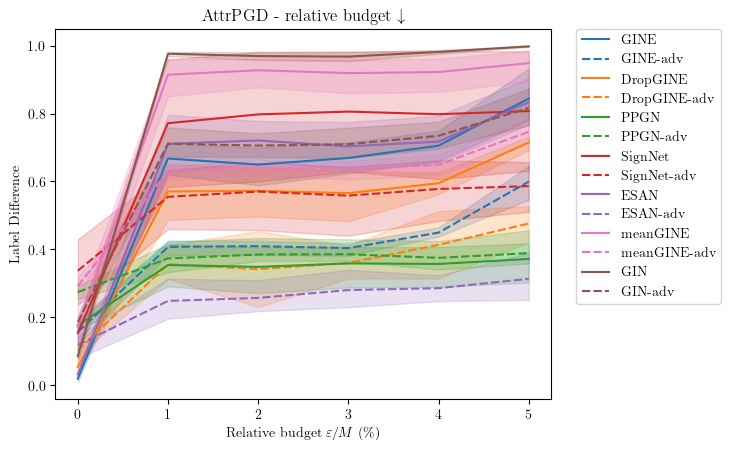

In [22]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.title("AttrPGD - relative budget $\\downarrow$")
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([i for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_attrpgd_lbl_diff_rel.pgf"), bbox_inches='tight')

## Random Perturbations

In [23]:
baseline_data = orig_data[orig_data["model_type"]=="Baseline"]
baseline_acc = baseline_data["acc"].mean()
baseline_lbl_diff = baseline_data["lbl_diff"].mean()
baseline_acc, baseline_lbl_diff

(0.4842105263157895, 0.46218724188051724)

In [24]:
def reduce_data(df):
    groupby = ["model", "task", "budget"]
    df["count"] = df.groupby(groupby)['y'].transform('size')

    per_model = group(df, groupby).mean().reset_index()
    append_model_type(per_model)
    return per_model

tasks = ["add_rdm_undir_edges", "drop_rdm_undir_edges", "rewire_rdm_undir_edges", "rdm_node_attr_change", "rdm_edge_attr_change"]
rdm_data = load_data(all_tasks, dataset_name, tasks, apply_transform=reduce_data)
assert (rdm_data["count"]==95).all()

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:04<00:00, 15.38it/s]


,model_type,acc,acc-adv,diff_acc,lbl_diff,lbl_diff-adv,diff_lbl_diff
0,DropGINE,$7.135 \pm 3.008$,$6.845 \pm 2.968$,$-0.29$,$0.045 \pm 0.017$,$0.045 \pm 0.017$,$0.0$
1,ESAN,$4.321 \pm 0.147$,$8.293 \pm 1.296$,$3.972$,$0.023 \pm 0.001$,$0.055 \pm 0.005$,$-0.032$
2,GIN,$3.135 \pm 0.699$,$2.906 \pm 0.319$,$-0.229$,$0.016 \pm 0.002$,$0.018 \pm 0.001$,$-0.002$
3,GINE,$3.597 \pm 0.309$,$5.512 \pm 0.555$,$1.915$,$0.019 \pm 0.001$,$0.032 \pm 0.002$,$-0.013$
4,PPGN,$10.806 \pm 2.39$,$19.964 \pm 3.946$,$9.158$,$0.052 \pm 0.012$,$0.113 \pm 0.031$,$-0.061$
5,SignNet,$3.001 \pm 0.757$,$4.211 \pm 3.617$,$1.21$,$0.013 \pm 0.006$,$0.018 \pm 0.019$,$-0.005$
6,meanGINE,$9.818 \pm 6.097$,$3.153 \pm 0.478$,$-6.665$,$0.057 \pm 0.041$,$0.016 \pm 0.003$,$0.041$


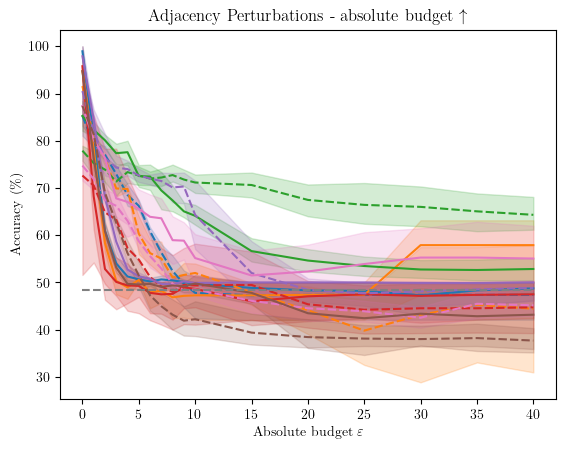

In [25]:
## ADJACENCY - ABS
adjrdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_abs", "drop_rdm_undir_edges_abs"])]).copy()
adjrmd_per_model = group(adjrdm_abs_data, ["model", "budget"]).mean().reset_index()
adjrmd_per_model["model_type"] = [model_name.split("_")[0] for model_name in adjrmd_per_model["model"].astype("str")]

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
append_model_type(adjrmd_per_model)
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")

adjrmd_per_model["acc"] = 100*adjrmd_per_model["acc"]

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="acc", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(adjrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("Adjacency Perturbations - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmadj_acc_abs.pgf"), bbox_inches='tight')

AAB_acc_df = compute_baseline_score(adjrmd_per_model, 100*baseline_acc, "acc")
AAB_lbl_diff_df = compute_baseline_score(adjrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)
AAB_df = AAB_acc_df.merge(AAB_lbl_diff_df[["model", "lbl_diff"]], on="model")
advtrain_to_table(AAB_df)

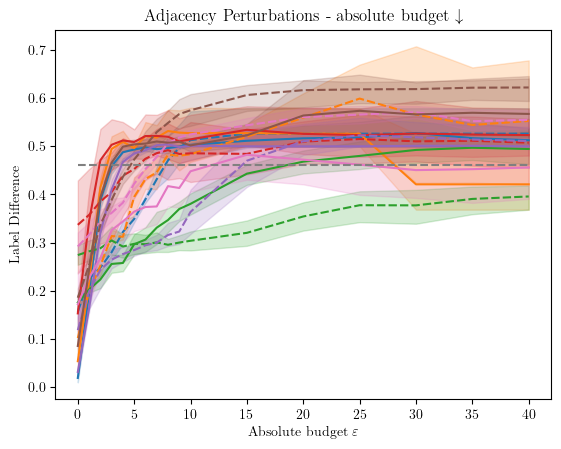

In [26]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("Adjacency Perturbations - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmadj_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,acc,acc-adv,diff_acc,lbl_diff,lbl_diff-adv,diff_lbl_diff
0,DropGINE,$5.445 \pm 1.302$,$11.616 \pm 0.801$,$6.171$,$0.031 \pm 0.006$,$0.078 \pm 0.004$,$-0.047$
1,ESAN,$8.109 \pm 0.418$,$21.181 \pm 2.568$,$13.072$,$0.053 \pm 0.003$,$0.145 \pm 0.019$,$-0.092$
2,GIN,$5.546 \pm 0.526$,$7.102 \pm 1.234$,$1.556$,$0.032 \pm 0.003$,$0.041 \pm 0.006$,$-0.009$
3,GINE,$6.497 \pm 0.501$,$12.149 \pm 0.833$,$5.652$,$0.039 \pm 0.004$,$0.081 \pm 0.002$,$-0.042$
4,PPGN,$23.936 \pm 3.37$,$23.715 \pm 3.279$,$-0.221$,$0.157 \pm 0.035$,$0.158 \pm 0.028$,$-0.001$
5,SignNet,$4.442 \pm 1.87$,$9.643 \pm 9.128$,$5.201$,$0.021 \pm 0.011$,$0.046 \pm 0.053$,$-0.025$
6,meanGINE,$16.182 \pm 6.879$,$7.37 \pm 0.672$,$-8.812$,$0.102 \pm 0.054$,$0.035 \pm 0.004$,$0.067$


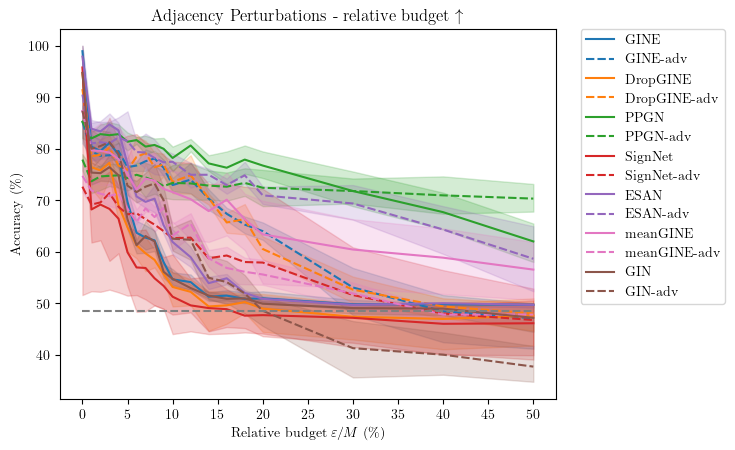

In [27]:
## ADJACENCY - REL
adjrdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_rel", "drop_rdm_undir_edges_rel"])]).copy()
adjrmd_per_model = group(adjrdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(adjrmd_per_model)

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
# append_model_type(adjrmd_per_model)
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")
adjrmd_per_model["acc"] = 100*adjrmd_per_model["acc"]

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="acc", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(adjrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("Adjacency Perturbations - relative budget $\\uparrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmadj_acc_rel.pgf"), bbox_inches='tight')

AAB_acc_df = compute_baseline_score(adjrmd_per_model, 100*baseline_acc, "acc")
AAB_lbl_diff_df = compute_baseline_score(adjrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)
AAB_df = AAB_acc_df.merge(AAB_lbl_diff_df[["model", "lbl_diff"]], on="model")
advtrain_to_table(AAB_df)

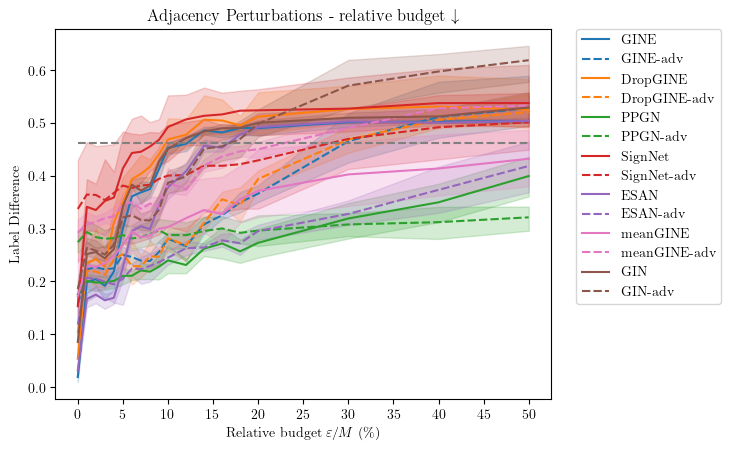

In [28]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("Adjacency Perturbations - relative budget $\\downarrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmadj_lbl_diff_rel.pgf"), bbox_inches='tight')

,model_type,acc,acc-adv,diff_acc,lbl_diff,lbl_diff-adv,diff_lbl_diff
0,DropGINE,$21.607 \pm 3.706$,$18.709 \pm 2.338$,$-2.898$,$0.16 \pm 0.036$,$0.128 \pm 0.021$,$0.032$
1,ESAN,$21.769 \pm 3.184$,$18.383 \pm 3.879$,$-3.386$,$0.16 \pm 0.03$,$0.12 \pm 0.028$,$0.04$
2,GIN,$2.388 \pm 0.646$,$3.394 \pm 0.5$,$1.006$,$0.018 \pm 0.005$,$0.019 \pm 0.002$,$-0.001$
3,GINE,$24.683 \pm 1.42$,$13.03 \pm 2.217$,$-11.653$,$0.189 \pm 0.013$,$0.072 \pm 0.011$,$0.117$
4,PPGN,$16.18 \pm 2.602$,$18.064 \pm 2.949$,$1.884$,$0.081 \pm 0.028$,$0.089 \pm 0.028$,$-0.008$
5,SignNet,$33.24 \pm 6.997$,$8.945 \pm 5.926$,$-24.295$,$0.209 \pm 0.046$,$0.027 \pm 0.023$,$0.182$
6,meanGINE,$10.655 \pm 5.491$,$2.611 \pm 0.346$,$-8.044$,$0.063 \pm 0.035$,$0.015 \pm 0.002$,$0.048$


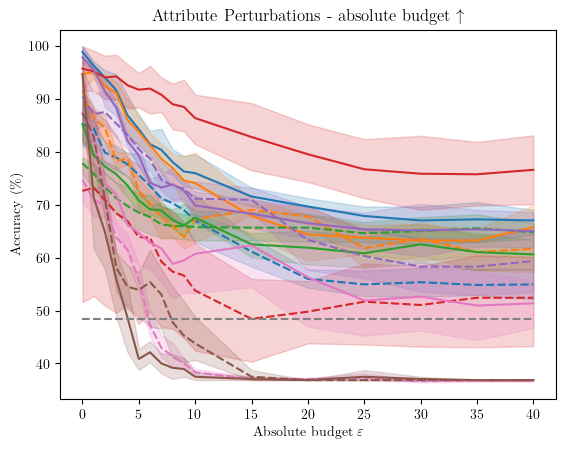

In [29]:
## ATTRIBUTES - ABS
attrrdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rdm_node_attr_change_abs", "rdm_edge_attr_change_abs"])]).copy()
attrrmd_per_model = group(attrrdm_abs_data, ["model", "budget"]).mean().reset_index()
attrrmd_per_model["model_type"] = [model_name.split("_")[0] for model_name in attrrmd_per_model["model"].astype("str")]

attrrmd_per_model = pd.concat([attrrmd_per_model, orig_per_model]).reset_index()
attrrmd_per_model = remove_unused_categories(attrrmd_per_model[attrrmd_per_model["model_type"]!="Baseline"])
append_model_type(attrrmd_per_model)
attrrmd_per_model = rename_col(attrrmd_per_model, "model_type", "model type")

attrrmd_per_model["acc"] = 100*attrrmd_per_model["acc"]

plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="acc", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(attrrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("Attribute Perturbations - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmattr_acc_abs.pgf"), bbox_inches='tight')

AAB_acc_df = compute_baseline_score(attrrmd_per_model, 100*baseline_acc, "acc")
AAB_lbl_diff_df = compute_baseline_score(attrrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)
AAB_df = AAB_acc_df.merge(AAB_lbl_diff_df[["model", "lbl_diff"]], on="model")
advtrain_to_table(AAB_df)

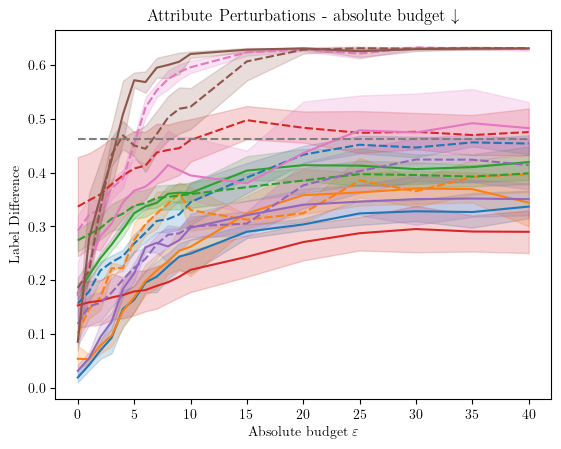

In [30]:
plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(attrrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("Attribute Perturbations - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmattr_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,acc,acc-adv,diff_acc,lbl_diff,lbl_diff-adv,diff_lbl_diff
0,DropGINE,$36.279 \pm 2.885$,$26.826 \pm 1.903$,$-9.453$,$0.304 \pm 0.028$,$0.207 \pm 0.022$,$0.097$
1,ESAN,$32.673 \pm 2.186$,$31.643 \pm 2.047$,$-1.03$,$0.267 \pm 0.019$,$0.234 \pm 0.022$,$0.033$
2,GIN,$5.119 \pm 2.103$,$7.649 \pm 1.142$,$2.53$,$0.037 \pm 0.016$,$0.044 \pm 0.007$,$-0.007$
3,GINE,$36.762 \pm 2.779$,$24.91 \pm 2.599$,$-11.852$,$0.306 \pm 0.027$,$0.178 \pm 0.018$,$0.128$
4,PPGN,$23.29 \pm 1.215$,$22.128 \pm 3.723$,$-1.162$,$0.157 \pm 0.011$,$0.135 \pm 0.033$,$0.022$
5,SignNet,$42.405 \pm 5.501$,$15.43 \pm 12.1$,$-26.975$,$0.273 \pm 0.051$,$0.059 \pm 0.067$,$0.214$
6,meanGINE,$17.948 \pm 6.27$,$5.975 \pm 0.967$,$-11.973$,$0.119 \pm 0.058$,$0.031 \pm 0.007$,$0.088$


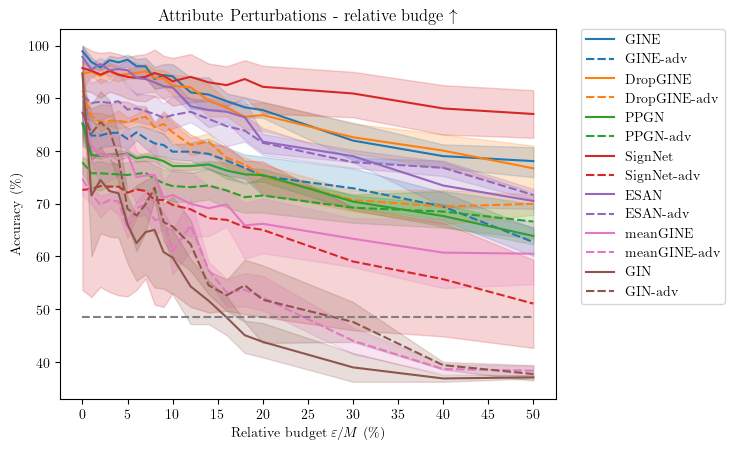

In [31]:
## ATTRIBUTES - REL
attrrdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rdm_node_attr_change_rel", "rdm_edge_attr_change_rel"])]).copy()
attrrmd_per_model = group(attrrdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(attrrmd_per_model)

attrrmd_per_model = pd.concat([attrrmd_per_model, orig_per_model]).reset_index()
attrrmd_per_model = remove_unused_categories(attrrmd_per_model[attrrmd_per_model["model_type"]!="Baseline"])
# append_model_type(attrrmd_per_model)
attrrmd_per_model = rename_col(attrrmd_per_model, "model_type", "model type")
attrrmd_per_model["acc"] = 100*attrrmd_per_model["acc"]

plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="acc", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(attrrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("Attribute Perturbations - relative budge $\\uparrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmattr_acc_rel.pgf"), bbox_inches='tight')

AAB_acc_df = compute_baseline_score(attrrmd_per_model, 100*baseline_acc, "acc")
AAB_lbl_diff_df = compute_baseline_score(attrrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)
AAB_df = AAB_acc_df.merge(AAB_lbl_diff_df[["model", "lbl_diff"]], on="model")
advtrain_to_table(AAB_df)

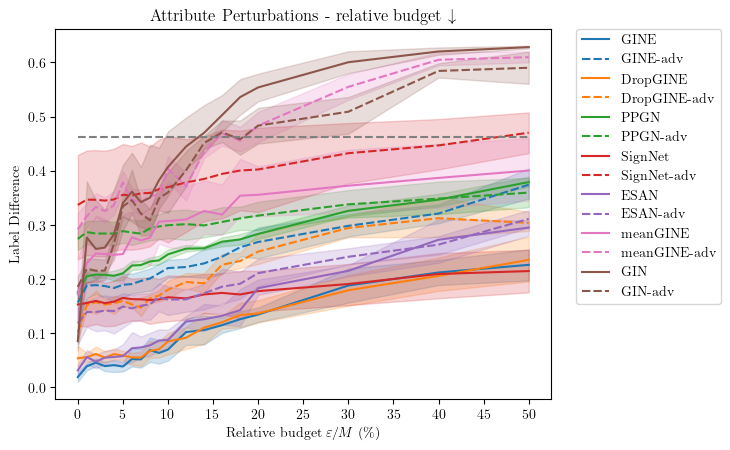

In [32]:
plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(attrrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("Attribute Perturbations - relative budget $\\downarrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmattr_lbl_diff_rel.pgf"), bbox_inches='tight')

,model_type,acc,acc-adv,diff_acc,lbl_diff,lbl_diff-adv,diff_lbl_diff
0,DropGINE,$14.039 \pm 7.016$,$14.285 \pm 3.224$,$0.246$,$0.096 \pm 0.057$,$0.088 \pm 0.032$,$0.008$
1,ESAN,$18.003 \pm 3.289$,$16.01 \pm 2.604$,$-1.993$,$0.125 \pm 0.033$,$0.101 \pm 0.025$,$0.024$
2,GIN,$12.77 \pm 7.136$,$3.389 \pm 0.615$,$-9.381$,$0.083 \pm 0.052$,$0.019 \pm 0.001$,$0.064$
3,GINE,$17.356 \pm 7.011$,$12.868 \pm 4.776$,$-4.488$,$0.126 \pm 0.057$,$0.082 \pm 0.033$,$0.044$
4,PPGN,$25.905 \pm 3.352$,$23.759 \pm 3.079$,$-2.146$,$0.176 \pm 0.033$,$0.163 \pm 0.03$,$0.013$
5,SignNet,$6.357 \pm 4.196$,$11.353 \pm 9.446$,$4.996$,$0.036 \pm 0.026$,$0.052 \pm 0.05$,$-0.016$
6,meanGINE,$7.682 \pm 4.829$,$3.189 \pm 0.437$,$-4.493$,$0.041 \pm 0.029$,$0.016 \pm 0.002$,$0.025$


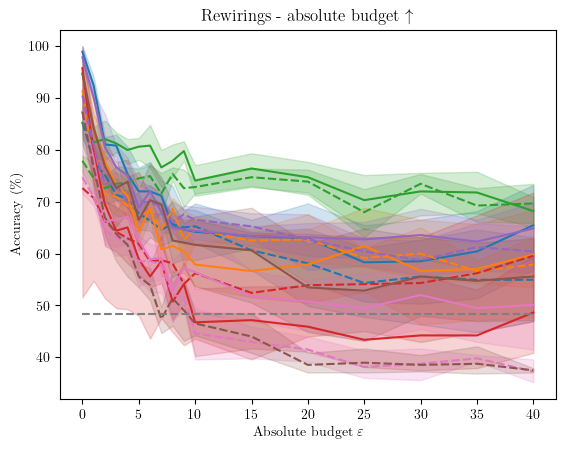

In [33]:
## REWIRE - ABS
rewirerdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_abs"])]).copy()
rewirermd_per_model = group(rewirerdm_abs_data, ["model", "budget"]).mean().reset_index()
rewirermd_per_model["model_type"] = [model_name.split("_")[0] for model_name in rewirermd_per_model["model"].astype("str")]

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
append_model_type(rewirermd_per_model)
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")

rewirermd_per_model["acc"] = 100*rewirermd_per_model["acc"]

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="acc", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(rewirermd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("Rewirings - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmrewire_acc_abs.pgf"), bbox_inches='tight')

AAB_acc_df = compute_baseline_score(rewirermd_per_model, 100*baseline_acc, "acc")
AAB_lbl_diff_df = compute_baseline_score(rewirermd_per_model, baseline_lbl_diff, "lbl_diff", below=False)
AAB_df = AAB_acc_df.merge(AAB_lbl_diff_df[["model", "lbl_diff"]], on="model")
advtrain_to_table(AAB_df)

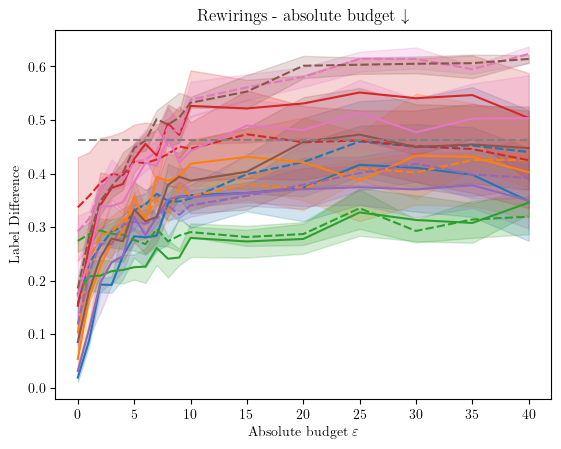

In [34]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("Rewirings - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmrewire_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,acc,acc-adv,diff_acc,lbl_diff,lbl_diff-adv,diff_lbl_diff
0,DropGINE,$19.946 \pm 5.904$,$20.867 \pm 2.165$,$0.921$,$0.147 \pm 0.054$,$0.15 \pm 0.018$,$-0.003$
1,ESAN,$25.792 \pm 1.86$,$22.914 \pm 1.985$,$-2.878$,$0.201 \pm 0.021$,$0.171 \pm 0.017$,$0.03$
2,GIN,$20.405 \pm 7.608$,$7.86 \pm 1.56$,$-12.545$,$0.148 \pm 0.062$,$0.042 \pm 0.006$,$0.106$
3,GINE,$25.296 \pm 4.297$,$19.942 \pm 2.394$,$-5.354$,$0.199 \pm 0.044$,$0.137 \pm 0.025$,$0.062$
4,PPGN,$31.397 \pm 3.403$,$24.821 \pm 2.969$,$-6.576$,$0.23 \pm 0.032$,$0.174 \pm 0.029$,$0.056$
5,SignNet,$11.938 \pm 2.073$,$15.22 \pm 12.637$,$3.282$,$0.063 \pm 0.02$,$0.069 \pm 0.077$,$-0.006$
6,meanGINE,$15.1 \pm 7.332$,$8.202 \pm 1.567$,$-6.898$,$0.093 \pm 0.057$,$0.039 \pm 0.004$,$0.054$


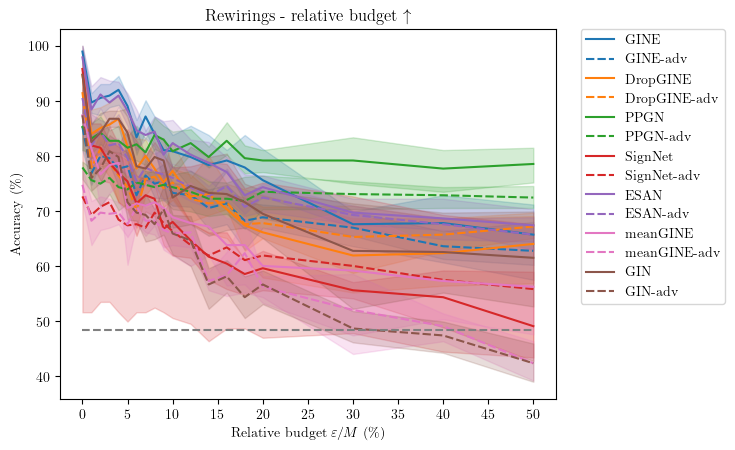

In [35]:
## REWIRE - REL
rewirerdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_rel"])]).copy()
rewirermd_per_model = group(rewirerdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(rewirermd_per_model)

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
# append_model_type(rewirermd_per_model)
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")
rewirermd_per_model["acc"] = 100*rewirermd_per_model["acc"]

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="acc", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(rewirermd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("Rewirings - relative budget $\\uparrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmrewire_acc_rel.pgf"), bbox_inches='tight')

AAB_acc_df = compute_baseline_score(rewirermd_per_model, 100*baseline_acc, "acc")
AAB_lbl_diff_df = compute_baseline_score(rewirermd_per_model, baseline_lbl_diff, "lbl_diff", below=False)
AAB_df = AAB_acc_df.merge(AAB_lbl_diff_df[["model", "lbl_diff"]], on="model")
advtrain_to_table(AAB_df)

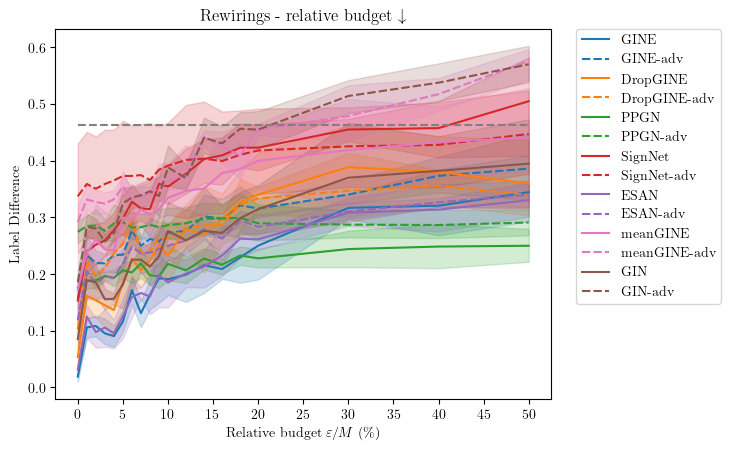

In [36]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette, style="model type", dashes=line_type) # err_style=None
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("Rewirings - relative budget $\\downarrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "MUTAG_rdmrewire_lbl_diff_rel.pgf"), bbox_inches='tight')

## Comparison between PGD and BruteForce

In [38]:
## ADJACENCY COMPARISON
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_data, group_by=adjpgd_abs_data["repeat"], shared_cols=["model", "id", "budget"], target_col="lbl_diff")
adjpgd_abs_agg["task_type"] = "adj_pgd_abs"
adjpgd_df = adjpgd_abs_agg[adjpgd_abs_agg["budget"]==1][["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'pgd_lbl_diff'})

adjbf_data_ = remove_unused_categories(adjbf_data[adjbf_data["perturbation"].isin(["add-edge", "drop-edge"])]).copy()
adjbf_agg = aggregate_over_splits(adjbf_data_, group_by=adjbf_data_["task"], shared_cols=["model", "id", "perturbation"], target_col="lbl_diff")
adjbf_agg = aggregate_over_splits(adjbf_agg, group_by=adjbf_agg["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
adjbf_agg["task_type"] = "bf"
bf_df = adjbf_agg[["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'bf_lbl_diff'})

adj_comparison_df = adjpgd_df.merge(bf_df, on=["model", "id"])
append_model_type(adj_comparison_df)
adj_comparison_df["better"] = adj_comparison_df["pgd_lbl_diff"] > adj_comparison_df["bf_lbl_diff"] - 1e-05
adj_comparison_df["lbl_diff_gap"] = adj_comparison_df["bf_lbl_diff"] - adj_comparison_df["pgd_lbl_diff"]

print(adj_comparison_df.groupby(by="model_type").count()["id"])

per_model = group(adj_comparison_df, ["model"]).mean().reset_index()
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "lbl_diff_gap", "better"]].groupby("model_type"))

model_type
DropGINE        95
DropGINE-adv    95
ESAN            95
ESAN-adv        95
GIN             95
GIN-adv         95
GINE            95
GINE-adv        95
PPGN            95
PPGN-adv        95
SignNet         95
SignNet-adv     95
meanGINE        95
meanGINE-adv    95
Name: id, dtype: int64


,model_type,lbl_diff_gap,better
0,DropGINE,$-0.104 \pm 0.129$,$0.8 \pm 0.136$
1,DropGINE-adv,$-0.04 \pm 0.032$,$0.695 \pm 0.094$
2,ESAN,$0.002 \pm 0.058$,$0.768 \pm 0.096$
3,ESAN-adv,$-0.037 \pm 0.092$,$0.705 \pm 0.127$
4,GIN,$0.001 \pm 0.001$,$0.947 \pm 0.037$
5,GIN-adv,$0.05 \pm 0.021$,$0.6 \pm 0.109$
6,GINE,$0.008 \pm 0.013$,$0.905 \pm 0.131$
7,GINE-adv,$0.023 \pm 0.023$,$0.642 \pm 0.172$
8,PPGN,$0.192 \pm 0.08$,$0.084 \pm 0.071$
9,PPGN-adv,$0.07 \pm 0.033$,$0.074 \pm 0.071$


In [39]:
## ATTRIBUTE COMPARISON
attrpgd_df = attrpgd_abs_data[attrpgd_abs_data["budget"]==1][["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'pgd_lbl_diff'}).copy()

attrbf_agg = aggregate_over_splits(attrbf_data, group_by=attrbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="lbl_diff")
attrbf_agg = aggregate_over_splits(attrbf_agg, group_by=attrbf_agg["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
attrbf_agg["task_type"] = "bf"
bf_df = attrbf_agg[["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'bf_lbl_diff'})

attr_comparison_df = attrpgd_df.merge(bf_df, on=["model", "id"])
append_model_type(attr_comparison_df)
attr_comparison_df["better"] = attr_comparison_df["pgd_lbl_diff"] > attr_comparison_df["bf_lbl_diff"] - 1e-05
attr_comparison_df["lbl_diff_gap"] = attr_comparison_df["bf_lbl_diff"] - attr_comparison_df["pgd_lbl_diff"]

print(attr_comparison_df.groupby(by="model_type").count()["id"])

per_model = group(attr_comparison_df, ["model"]).mean().reset_index()
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "lbl_diff_gap", "better"]].groupby("model_type"))

model_type
DropGINE        95
DropGINE-adv    95
ESAN            95
ESAN-adv        95
GINE            95
GINE-adv        95
PPGN            95
PPGN-adv        95
SignNet         95
SignNet-adv     95
meanGINE        95
meanGINE-adv    95
Name: id, dtype: int64


,model_type,lbl_diff_gap,better
0,DropGINE,$0.264 \pm 0.095$,$0.379 \pm 0.202$
1,DropGINE-adv,$0.236 \pm 0.054$,$0.316 \pm 0.083$
2,ESAN,$0.171 \pm 0.059$,$0.221 \pm 0.024$
3,ESAN-adv,$0.27 \pm 0.065$,$0.168 \pm 0.12$
4,GINE,$0.162 \pm 0.104$,$0.632 \pm 0.252$
5,GINE-adv,$0.196 \pm 0.043$,$0.189 \pm 0.177$
6,PPGN,$0.157 \pm 0.055$,$0.105 \pm 0.105$
7,PPGN-adv,$0.036 \pm 0.02$,$0.179 \pm 0.096$
8,SignNet,$0.122 \pm 0.144$,$0.6 \pm 0.137$
9,SignNet-adv,$0.119 \pm 0.075$,$0.389 \pm 0.196$
